# Clustering Emad 10x scRNA-Seq experiment

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)) [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html). We gratefully acknowledge the authors of Seurat for the tutorial. In the meanwhile, we have added and removed a few pieces.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/scEmad.h5ad'  # the file that will store the analysis results

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
sc.settings.set_figure_params(dpi=80)

Run this on bash to unzip 

In [3]:
adata = sc.read_10x_mtx(
    './10x_Emad_results/outs/filtered_feature_bc_matrix/',       # the directory with the `.mtx` file
    var_names='gene_symbols',                                    # use gene symbols for the variable names (variables-axis index)
    cache=True)                                                  # write a cache file for faster subsequent reading

... reading from cache file cache/10x_Emad_results-outs-filtered_feature_bc_matrix-matrix.h5ad


In [4]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [5]:
adata

View of AnnData object with n_obs × n_vars = 13410 × 33538 
    var: 'gene_ids', 'feature_types'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


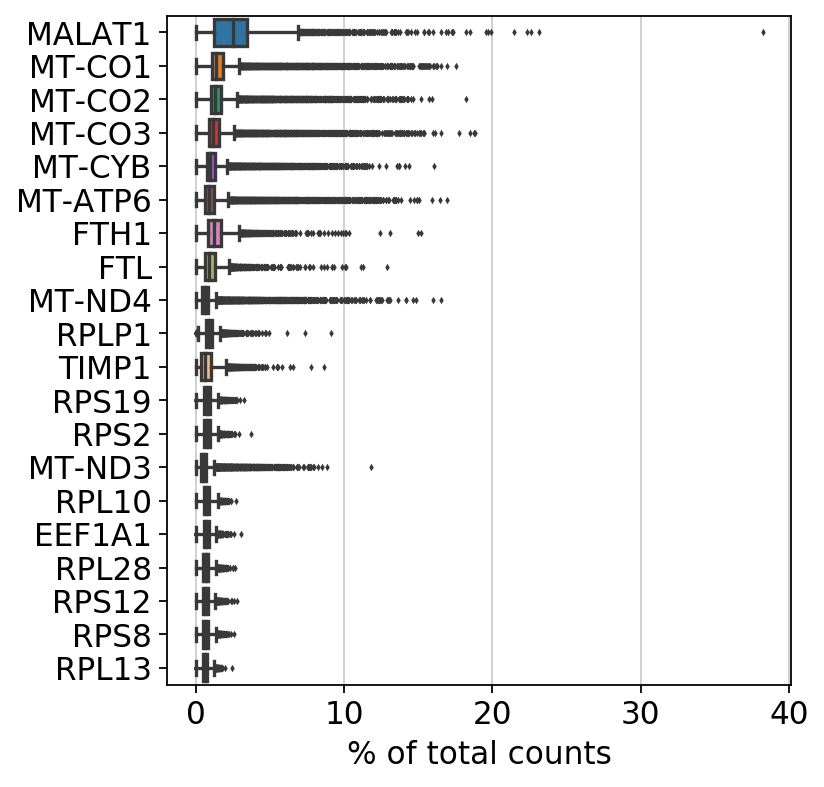

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering.

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Let us assemple some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

Note you can also use the function `pp.calculate_qc_metrics` to compute the fraction of mitochondrial genes and additional measures.

In [9]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

A violin plot of the computed quality measures.

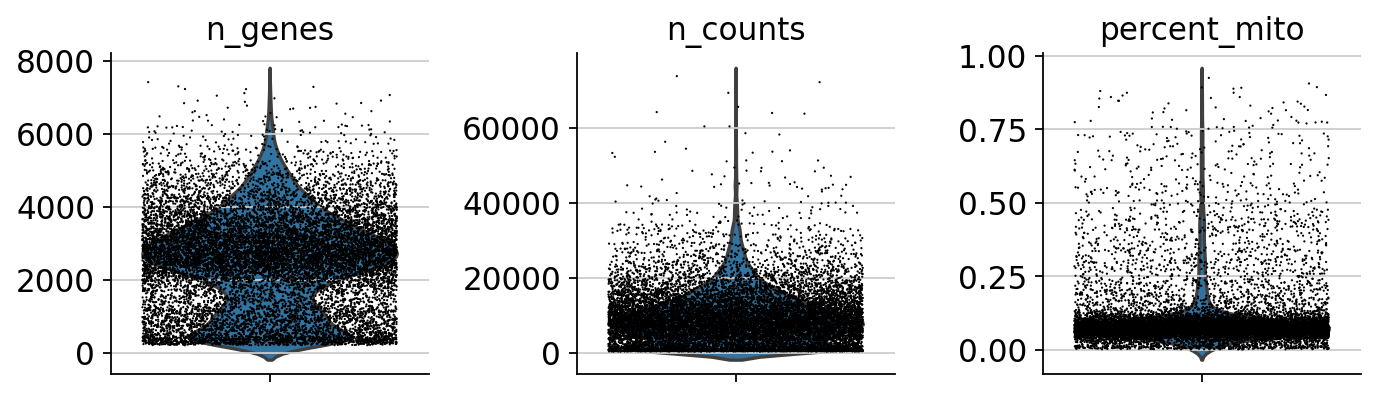

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

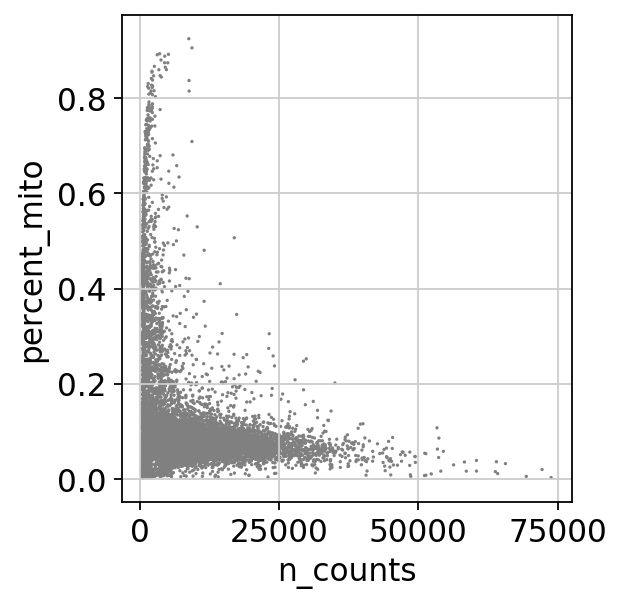

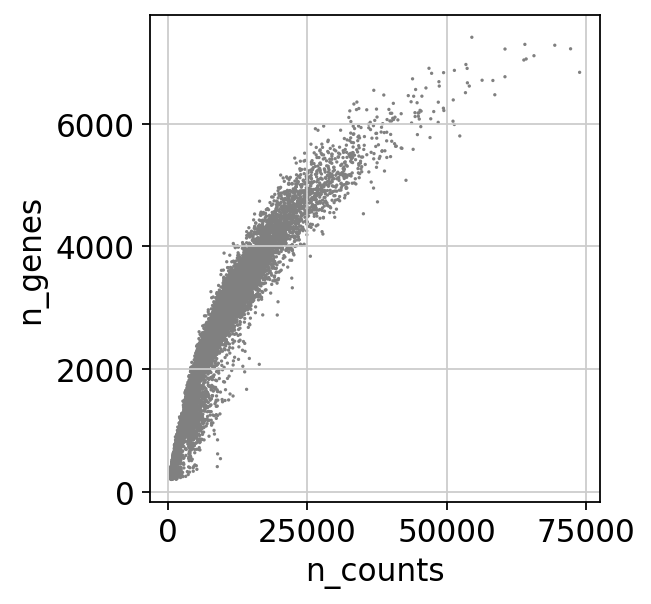

In [12]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [13]:
adata

AnnData object with n_obs × n_vars = 13391 × 20409 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

Actually do the filtering.

In [14]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [16]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Logarithmize the data.

In [17]:
sc.pp.log1p(adata)

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. While many people consider the normalized data matrix as the "relevant data" for visualization and differential testing, some would prefer to store the unnormalized data.

In [18]:
adata.raw = adata

Identify highly-variable genes.

In [19]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


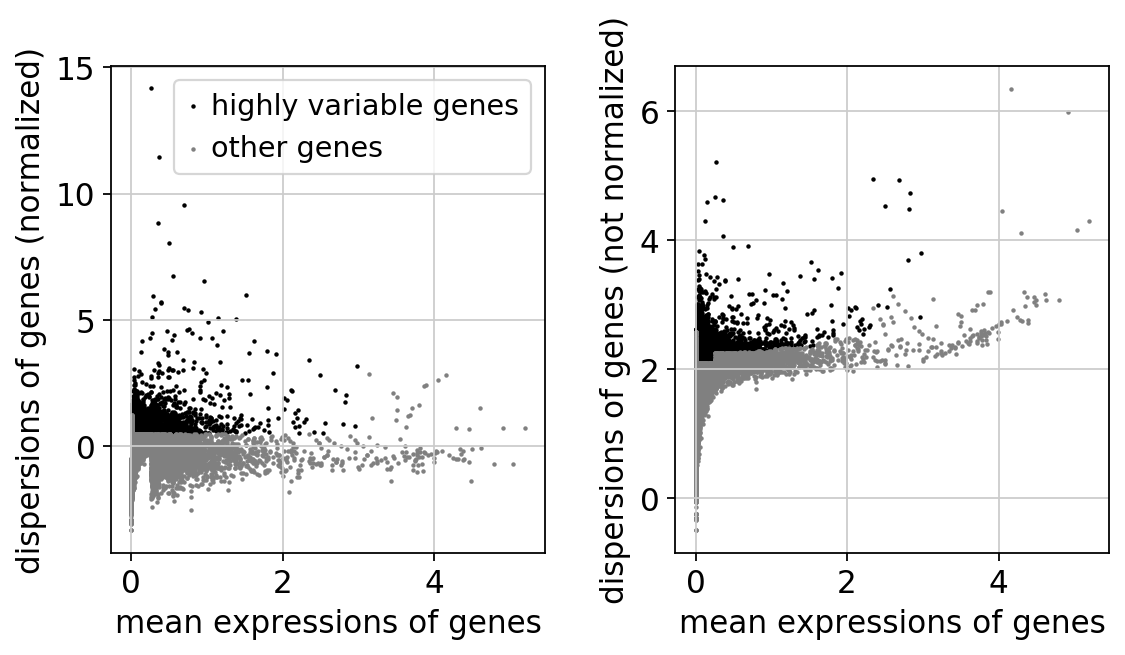

In [20]:
sc.pl.highly_variable_genes(adata)

Actually do the filtering.

In [21]:
adata = adata[:, adata.var['highly_variable']]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [22]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:09)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [23]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [24]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

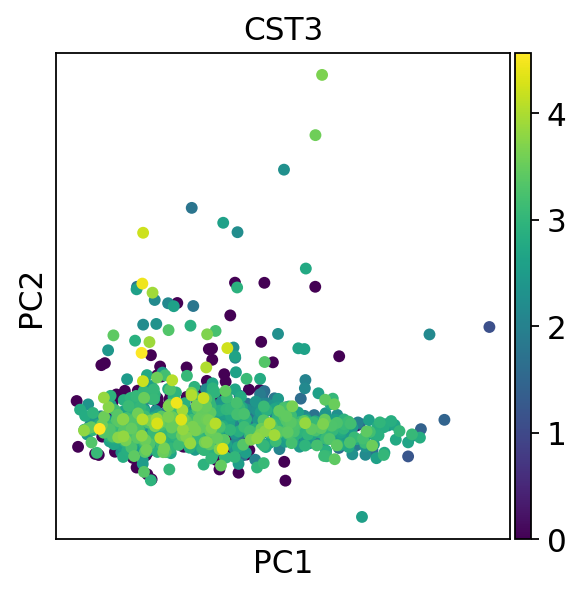

In [25]:
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

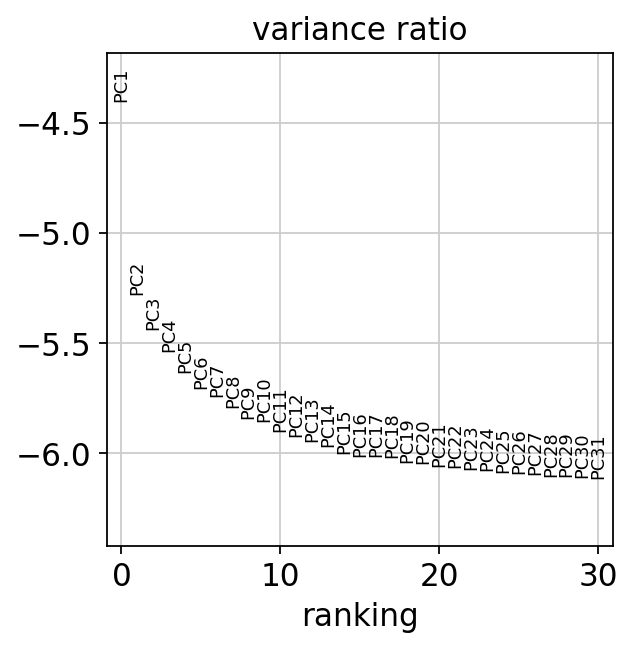

In [26]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [27]:
adata.write(results_file)

In [28]:
adata

AnnData object with n_obs × n_vars = 1052 × 5098 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [29]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)


## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [30]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


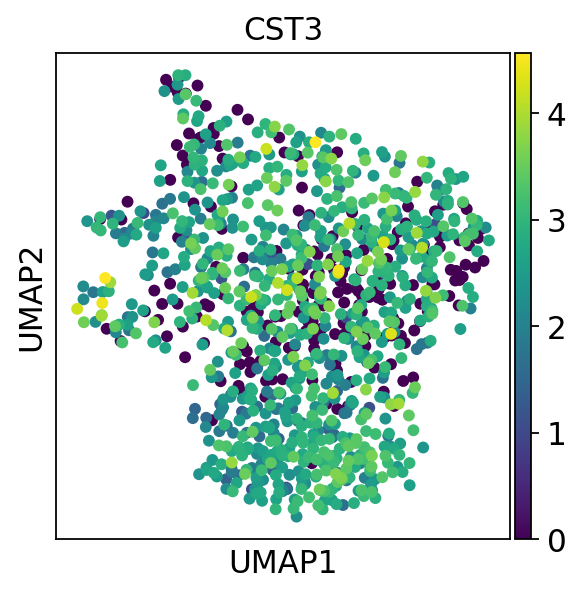

In [38]:
sc.pl.umap(adata, color=['CST3']) # , 'NKG7', 'PPBP']) 

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

In [42]:
# sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine et al. (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [43]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

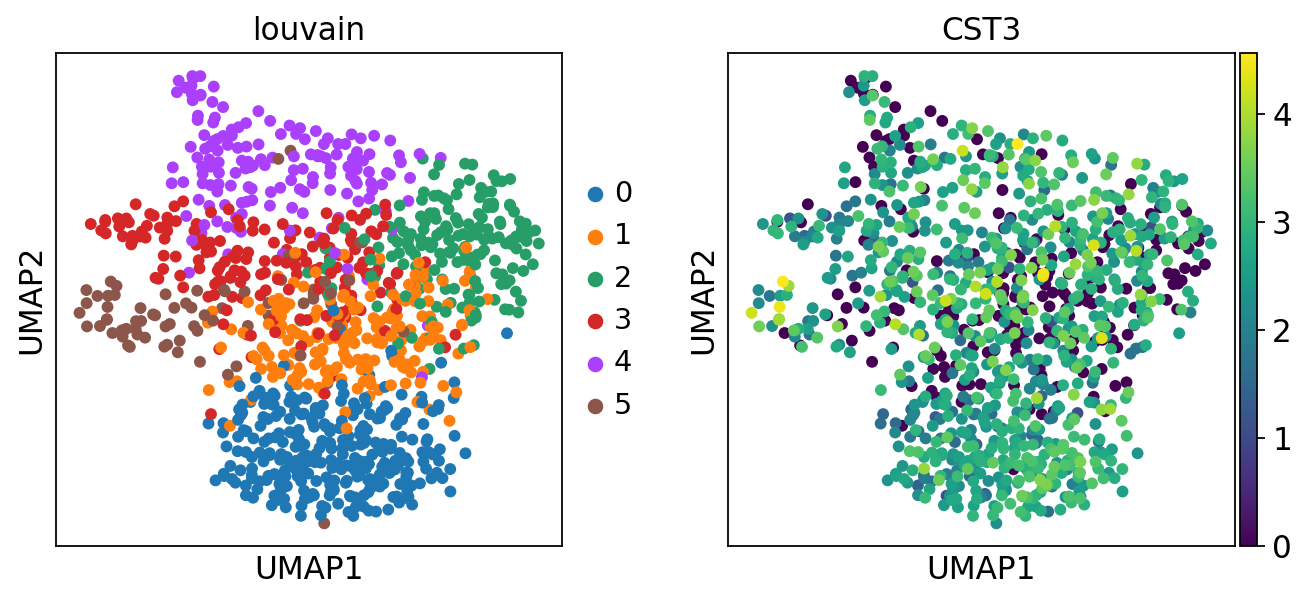

In [46]:
sc.pl.umap(adata, color=['louvain', 'CST3']) #, 'NKG7'])

Save the result.

In [47]:
adata.write(results_file)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


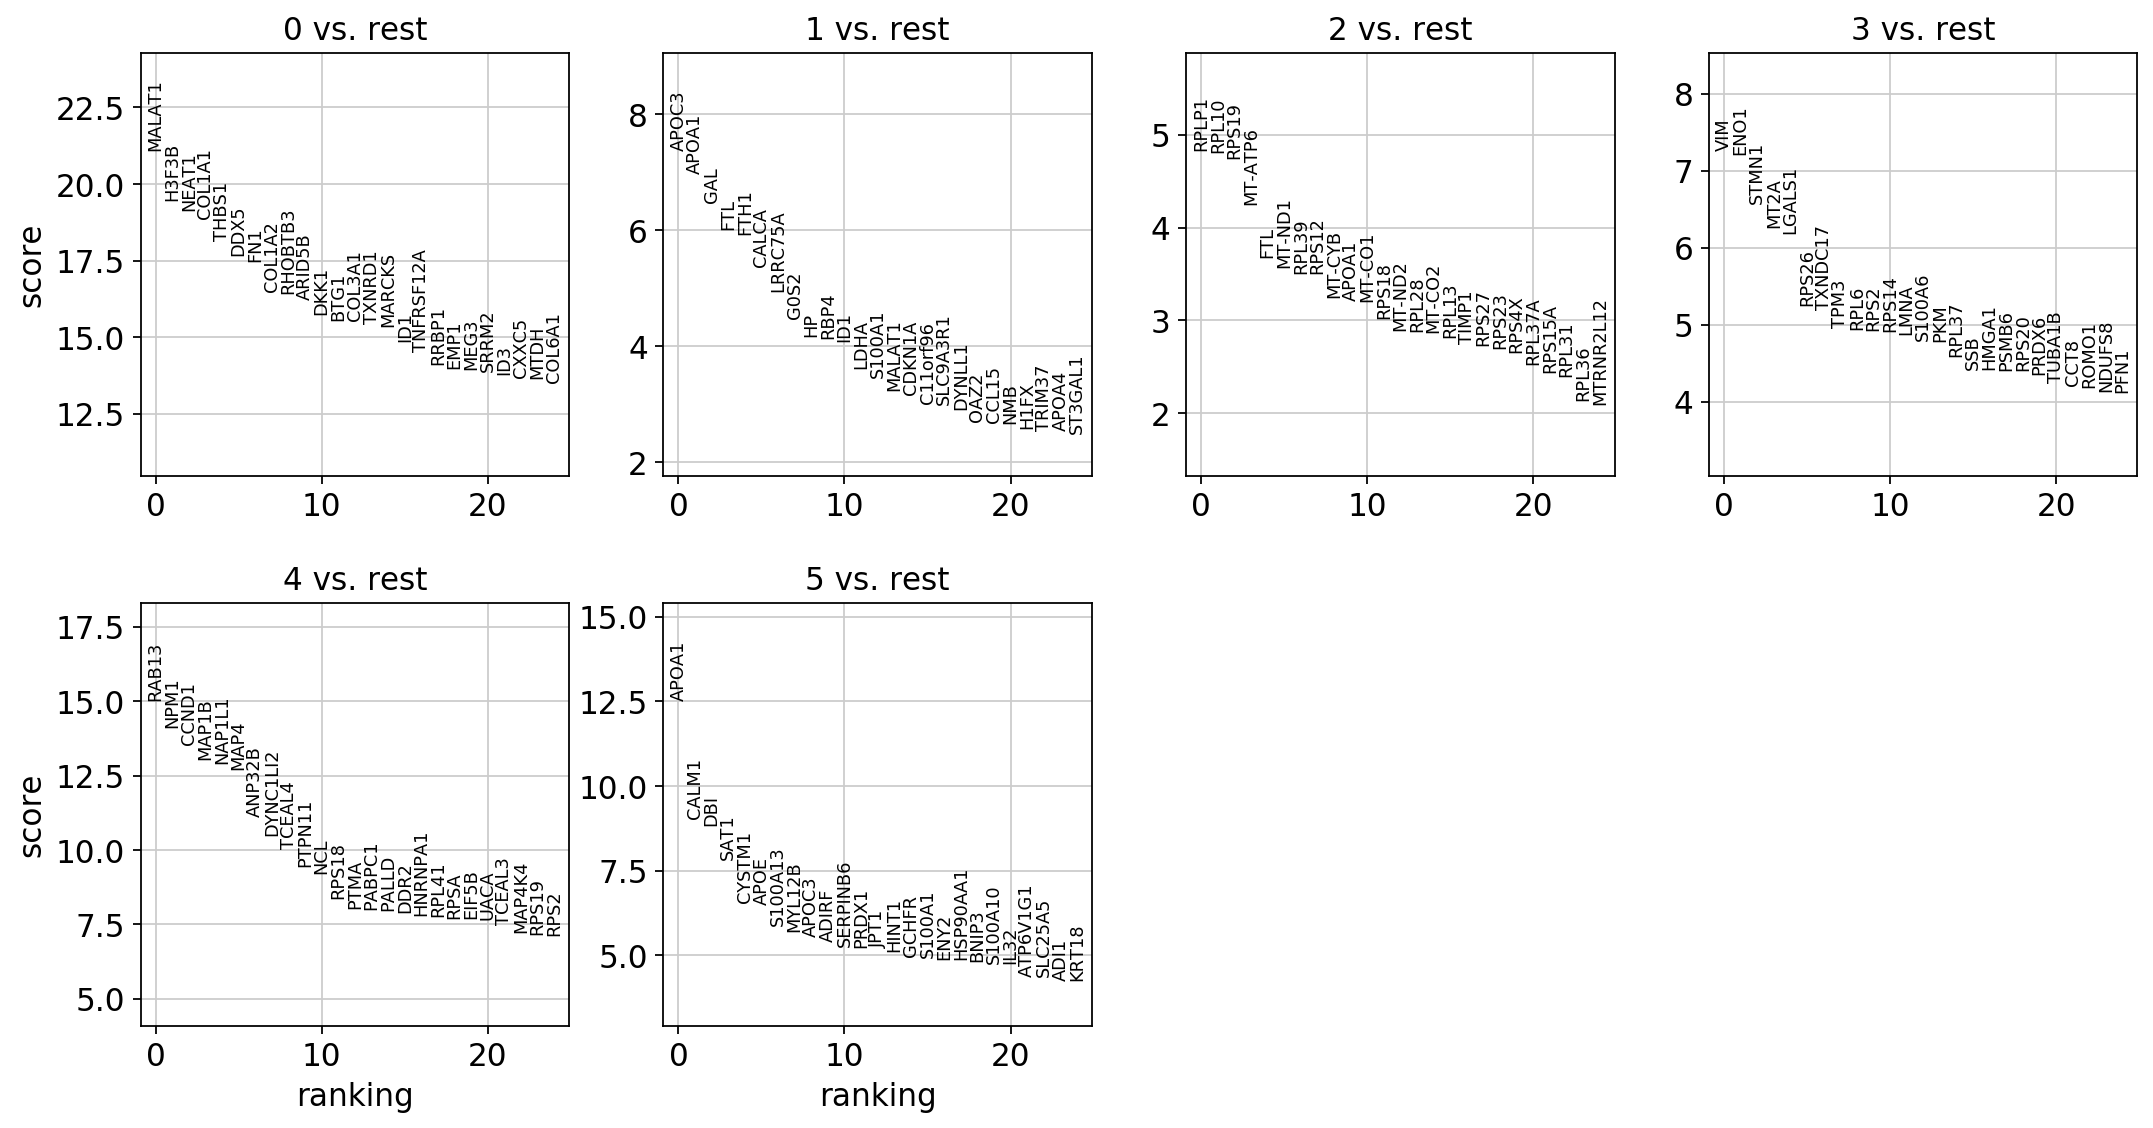

In [48]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [49]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:01)


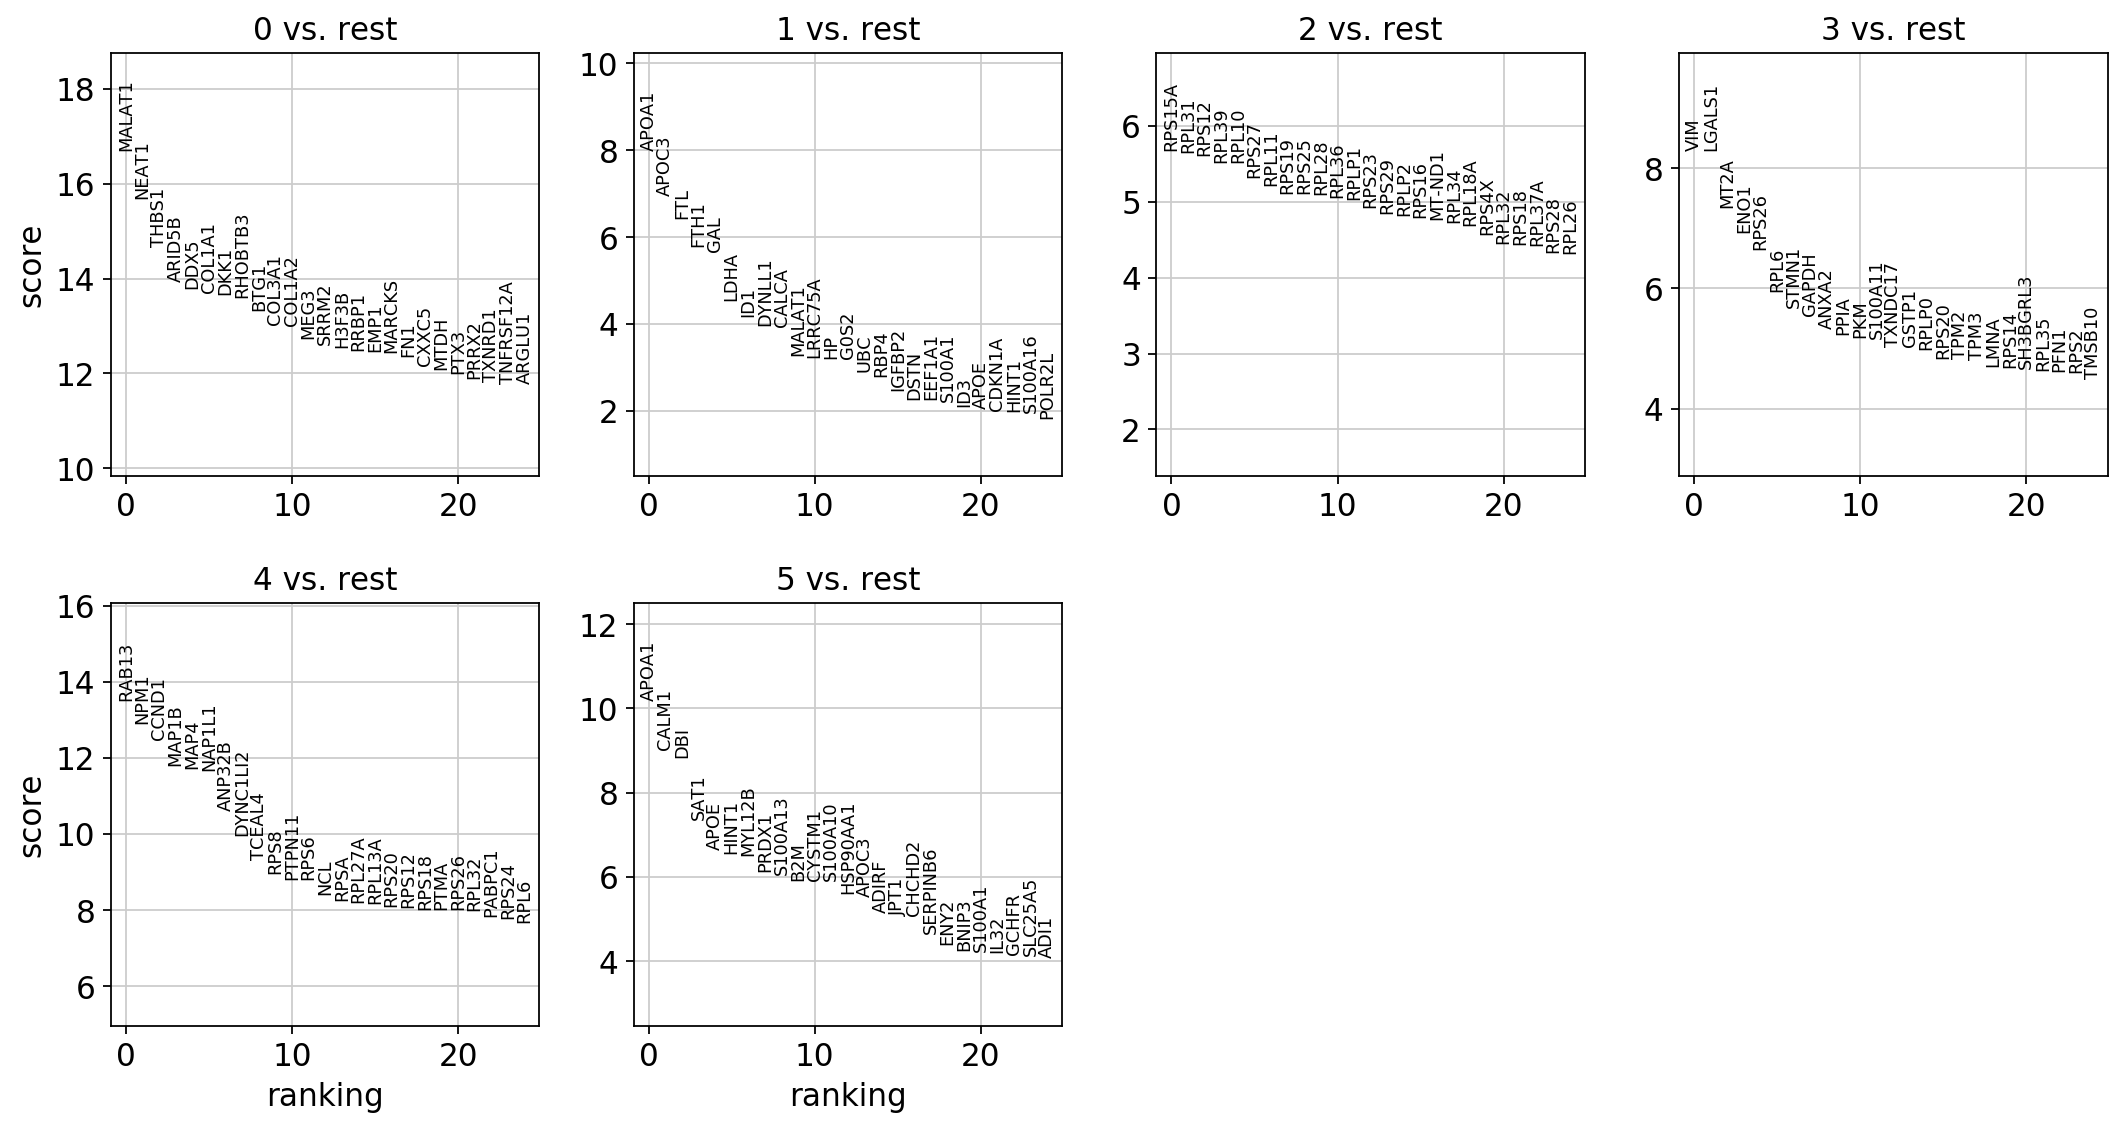

In [50]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [51]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:00:02)


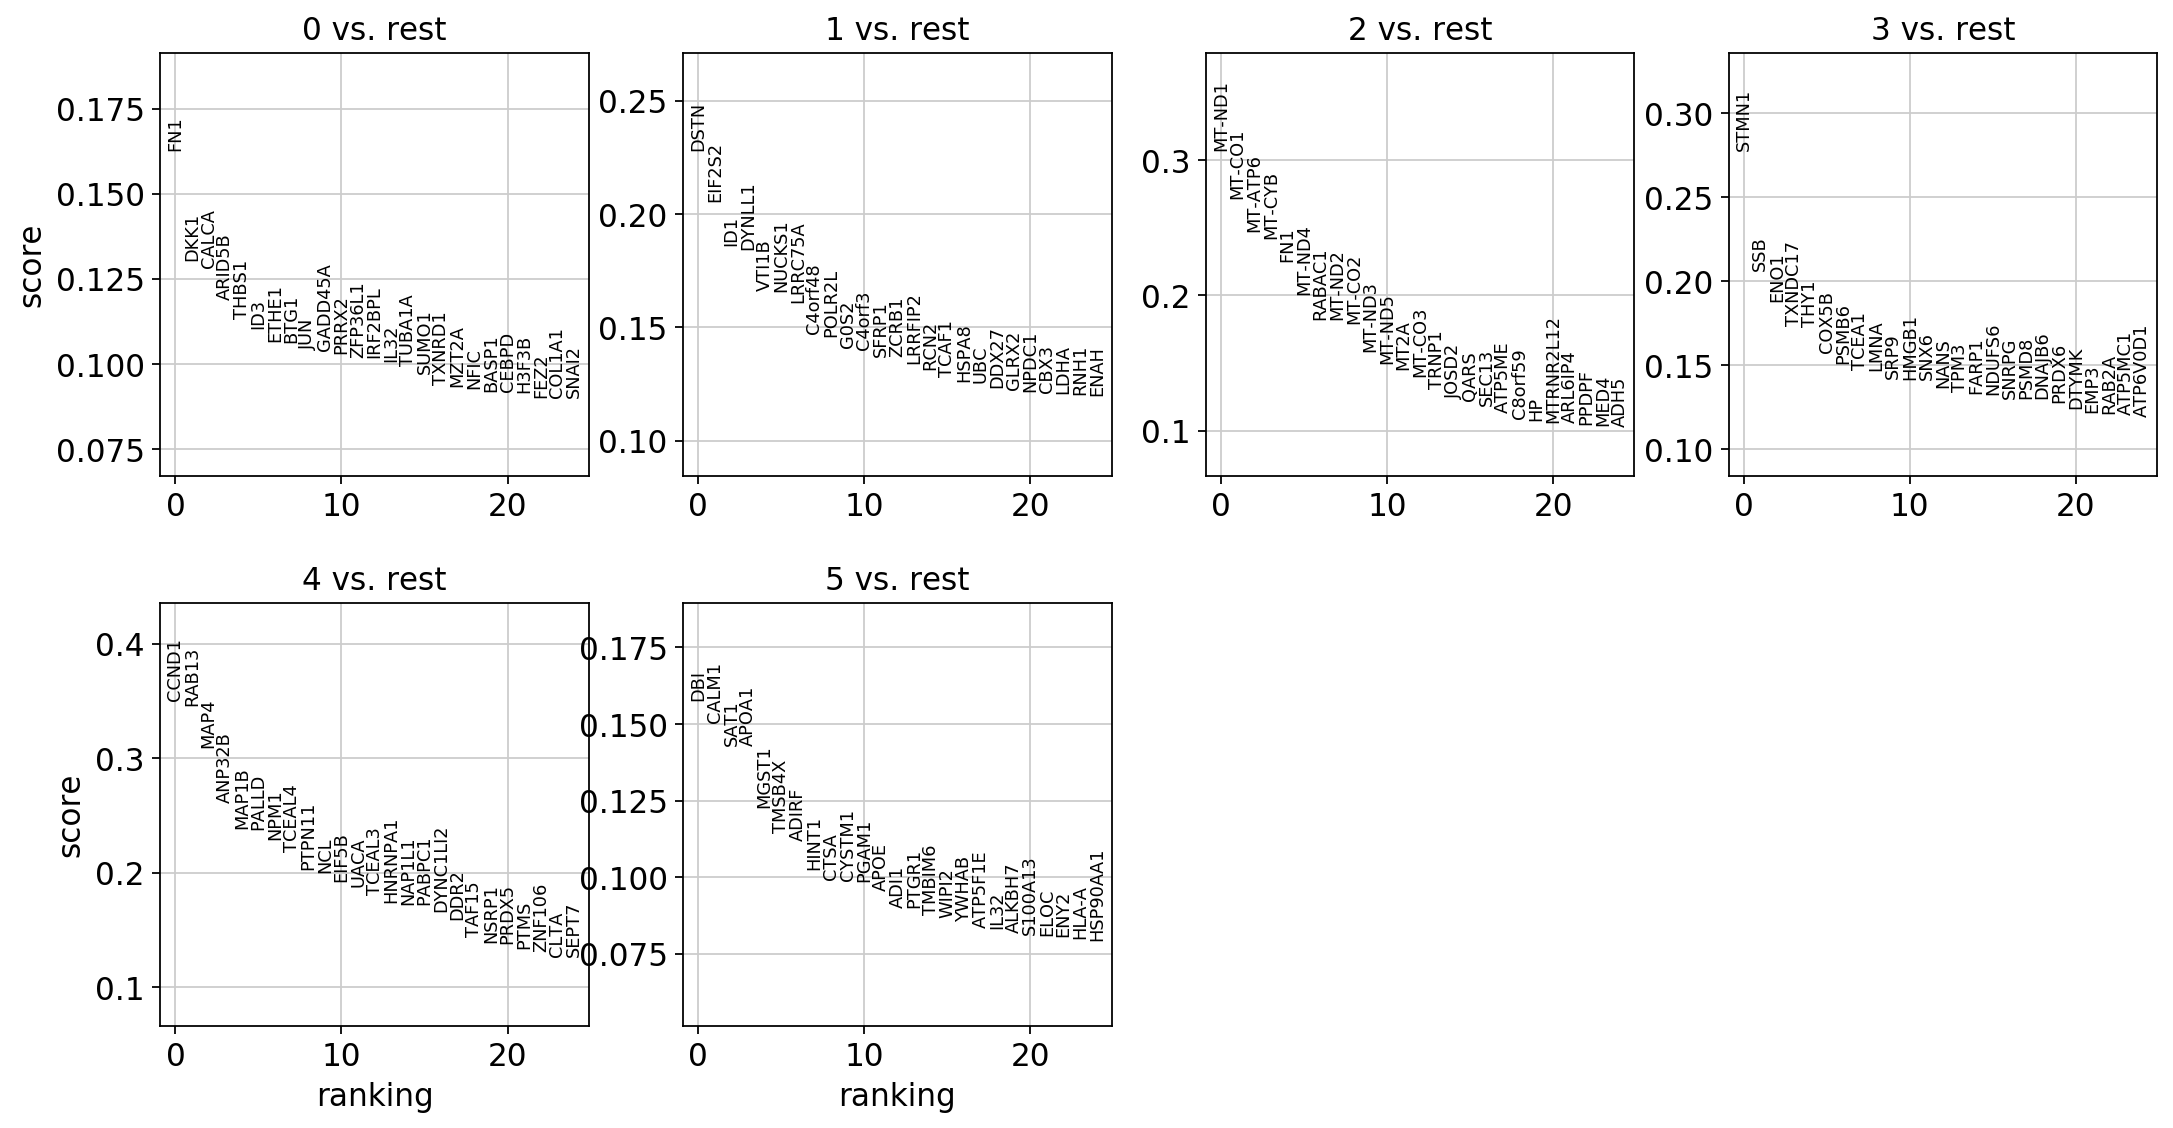

In [53]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [54]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [55]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [56]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5
0,MALAT1,APOA1,RPS15A,VIM,RAB13,APOA1
1,NEAT1,APOC3,RPL31,LGALS1,NPM1,CALM1
2,THBS1,FTL,RPS12,MT2A,CCND1,DBI
3,ARID5B,FTH1,RPL39,ENO1,MAP1B,SAT1
4,DDX5,GAL,RPL10,RPS26,MAP4,APOE


Get a table with the scores and groups.

In [57]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p
0,MALAT1,1.259490e-62,APOA1,1.297356e-15,RPS15A,1.375769e-08,VIM,1.073904e-16,RAB13,1.230027e-41,APOA1,2.059359e-24
1,NEAT1,1.591623e-55,APOC3,3.581172e-12,RPL31,1.552370e-08,LGALS1,1.104357e-16,NPM1,3.582859e-38,CALM1,1.666117e-19
2,THBS1,8.789601e-49,FTL,1.301758e-10,RPS12,2.033572e-08,MT2A,2.097491e-13,CCND1,8.270431e-36,DBI,1.030687e-18
3,ARID5B,3.911206e-44,FTH1,7.705388e-09,RPL39,3.375502e-08,ENO1,4.407658e-12,MAP1B,4.030206e-32,SAT1,1.819235e-13
4,DDX5,3.074388e-43,GAL,1.448895e-08,RPL10,3.430530e-08,RPS26,3.108903e-11,MAP4,9.854884e-32,APOE,2.928524e-11


Compare to a single cluster. 

ranking genes
    finished (0:00:00)


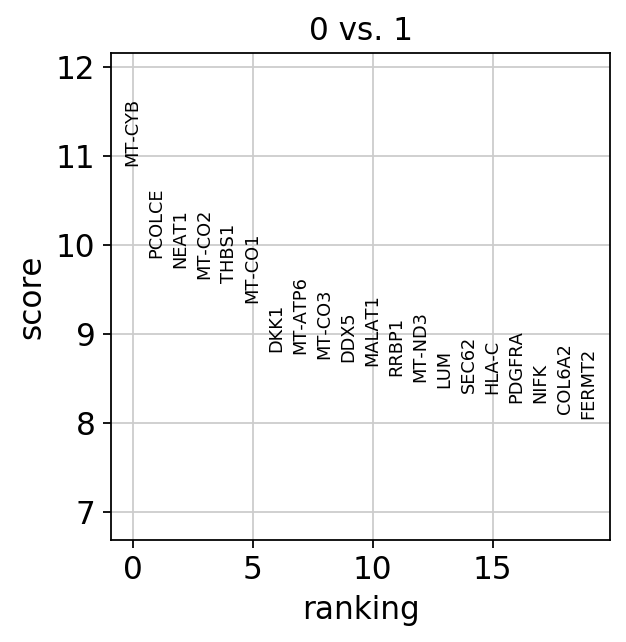

In [58]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

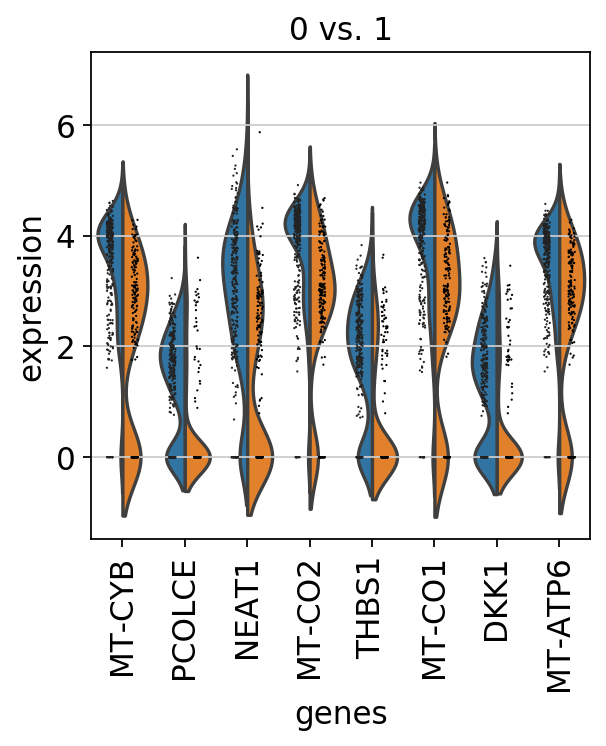

In [60]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object that computed differential expression by comparing to the rest of the groups.

In [61]:
adata = sc.read(results_file)

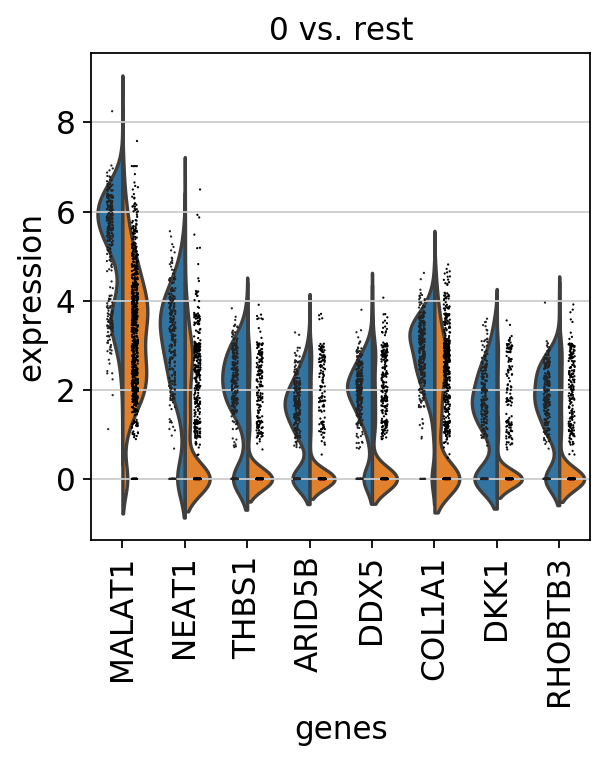

In [62]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

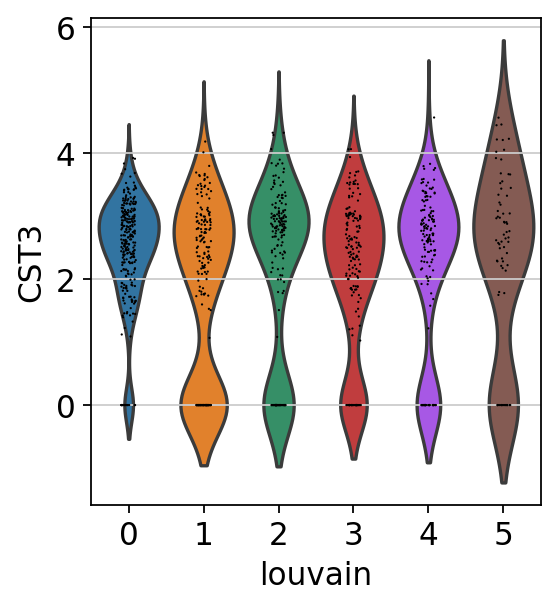

In [64]:
sc.pl.violin(adata, ['CST3']
#              , 'NKG7', 'PPBP']
             , groupby='louvain')

Actually mark the cell types.

In [69]:
# new_cluster_names = [
#     'CD4 T', 'CD14+ Monocytes',
#     'B', 'CD8 T', 
#     'NK', 'FCGR3A+ Monocytes',
#     'Dendritic', 'Megakaryocytes']
# adata.rename_categories('louvain', new_cluster_names)

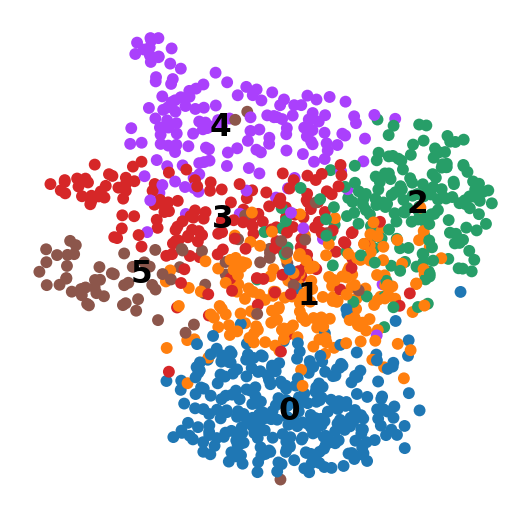

In [70]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

In [73]:
# ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

There is also a very compact violin plot.

In [75]:
# ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

During the course of this analysis, the AnnData accumlated the following annotations.

In [76]:
adata

AnnData object with n_obs × n_vars = 1052 × 5098 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [77]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations.

In [78]:
adata.X = None
adata.write('./write/pbmc3k_withoutX.h5ad', compression='gzip')

If you want to export to "csv", you have the following options:

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )